In [48]:
import pandas as pd
import numpy as np
import panel as pn
import seaborn as sns
pn.extension('tabulator')

import hvplot.pandas 
!pip install matplotlib 
!pip install scikit-learn  

import sklearn
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
#plt.style.use('ggplot')
pd.set_option('max_columns',200)


OptionError: Pattern matched multiple keys

In [ ]:
plt.style.use('ggplot')
pd.options.display.max_columns = 200
pd.options.display.max_rows = 50

In [ ]:
                                     Data Import, Preprocessing

In [99]:
dfcali  = pd.read_csv('/Users/maxi/Documents/coccid_dashboard/files/CALIFORNIA/calicounty.csv')
dfari = pd.read_csv('/Users/maxi/Documents/coccid_dashboard/files/ARIZONA COUNTY/aricounty.csv', thousands = ',')
dfcensus = pd.read_csv('/Users/maxi/Documents/coccid_dashboard/files/census/countyfips.csv')
dfclimcount = pd.read_csv('/Users/maxi/Documents/coccid_dashboard/files/climate/climdiv_county_year.csv') #climcount is deprecated (only the year no month granularity)

In [100]:
#data formatting: wide to long 
dfari = dfari.melt(id_vars = 'COUNTY')

In [101]:
#data cleanup 
dfari = dfari.rename(columns = {'COUNTY':'county', 'variable':'year', 'value':'case'})
dfari['case'] = dfari['case'].astype('float64')

dfcensus
dfcensus = dfcensus.rename(columns = {'name':'county'})
dfcensus['county'] = dfcensus['county'].str.lower()
substring_to_remove = ' county'
dfcensus['county'] = dfcensus['county'].str.replace(substring_to_remove, '')


dfari = dfari.rename(columns = {'COUNTY':'county', 'variable':'year', 'value':'case'})
dfari['county'] = dfari['county'].str.lower()
dfcali['county'] = dfcali['county'].str.lower()
#dfcali = dfcali.drop(['rate'], axis = 1) #i think this is dropping the whole DF love my life
dfcali.dropna()

print(dfcensus)

       fips         county state
0         0  united states   NaN
1      1000        alabama   NaN
2      1001        autauga    AL
3      1003        baldwin    AL
4      1005        barbour    AL
...     ...            ...   ...
3190  56037     sweetwater    WY
3191  56039          teton    WY
3192  56041          uinta    WY
3193  56043       washakie    WY
3194  56045         weston    WY

[3195 rows x 3 columns]


In [102]:
#addin state indicators 
dfcali['state'] = 'CA'
dfari['state'] = 'AZ'

In [103]:
dfcali

,county,year,case,rate,state
0,alameda,2001.0,7.0,0.5*,CA
1,alameda,2002.0,2.0,0.1*,CA
2,alameda,2003.0,9.0,0.7*,CA
3,alameda,2004.0,12.0,0.9*,CA
4,alameda,2005.0,11.0,0.8*,CA
...,...,...,...,...,...
1341,yuba,2019.0,5.0,6.4*,CA
1342,yuba,2020.0,2.0,2.5*,CA
1343,yuba,2021.0,2.0,2.6*,CA
1344,NaN,NaN,NaN,NaN,CA


In [104]:
#dropping any NA's and rate columns—we'll add it in later 
dfcali = dfcali.dropna()
dfcali = dfcali.drop(['rate'], axis=1)
dfcali.tail()

,county,year,case,state
1339,yuba,2017.0,3.0,CA
1340,yuba,2018.0,2.0,CA
1341,yuba,2019.0,5.0,CA
1342,yuba,2020.0,2.0,CA
1343,yuba,2021.0,2.0,CA


In [ ]:
dfcali.dtypes

In [ ]:
dfcali['year'] = dfcali['year'].astype('int64')
dfari['year'] = dfari['year'].astype('int64') #removing .0 in year for dfcali['year']
#dfcali['year'] = dfcali['year'].str.replace('.0', '', regex = False)


            Concatenating Arizona and California DataFrames by type, attach fips codes

In [ ]:
#concatenating dfcali|dfari 
aricalidf = pd.concat([dfcali,dfari], ignore_index = True) 
aricalidf = aricalidf.dropna()

In [ ]:
aricalicensus = pd.merge(aricalidf, dfcensus, on = ['county', 'state'], how = 'inner')
#aricalicensus = aricalicensus.query('(state == "AZ") | (state == "CA")')# have to delete redundant 

In [105]:
aricalicensus

,county,year,case,state,fips
0,alameda,2001,7.0,CA,6001
1,alameda,2002,2.0,CA,6001
2,alameda,2003,9.0,CA,6001
3,alameda,2004,12.0,CA,6001
4,alameda,2005,11.0,CA,6001
...,...,...,...,...,...
1453,yuma,2017,28.0,AZ,4027
1454,yuma,2018,27.0,AZ,4027
1455,yuma,2019,65.0,AZ,4027
1456,yuma,2020,52.0,AZ,4027


                    Importing California and Arizona Population Data 

In [ ]:
cali2000  = pd.read_csv('/Users/maxi/Documents/coccid_dashboard/files/census/cali2000.csv')
ari2000 = pd.read_csv('/Users/maxi/Documents/coccid_dashboard/files/census/ari2000.csv', thousands = ',')
cali2010 = pd.read_csv('/Users/maxi/Documents/coccid_dashboard/files/census/cali2010.csv')
ari2010 = pd.read_csv('/Users/maxi/Documents/coccid_dashboard/files/census/ari2010.csv')


In [ ]:
#formatting said data, wide to long, adding state columns, and concatenating
tari2000 = pd.melt(ari2000, id_vars=['county']) #melting columns
tcali2000 = pd.melt(cali2000, id_vars=['county'])
tari2010 = pd.melt(ari2010, id_vars=['county'])
tcali2010 = pd.melt(cali2010, id_vars=['county'])
tcali2000['state'] = 'CA'
tcali2010['state'] = 'CA'
tari2000['state'] = 'AZ'
tari2010['state'] = 'AZ'
aricali2000 = pd.concat([tari2000,tcali2000], ignore_index = True) #stacking dfcali|dfari vertically
aricali2010 = pd.concat([tari2010,tcali2010], ignore_index = True) #stacking dfcali|dfari vertically
aricali2000 = aricali2000.dropna()
censustotal = pd.concat([aricali2000, aricali2010],ignore_index = True)

In [ ]:
#cleaning dataframe 
censustotal['county'] = censustotal['county'].str.replace('.', '')
censustotal['county'] = censustotal['county'].str.replace('County', '')
censustotal #final census data 
censustotal['county'] = censustotal['county'].str.lower()
censustotal = censustotal.rename(columns={'value':'population'}) 
censustotal = censustotal.rename(columns={'variable':'year'}) 
censustotal['county'] = censustotal['county'].apply(lambda x: x.strip()) #rids of weird blankspace in census data
censustotal['year'] = censustotal['year'].astype('int64')
print(censustotal)

In [106]:
#county level populations fom 2000 - 2021 
censustotal

,county,year,population,state
0,apache,2000,69507.0,AZ
1,cochise,2000,118132.0,AZ
2,coconino,2000,116773.0,AZ
3,gila,2000,51332.0,AZ
4,graham,2000,33511.0,AZ
...,...,...,...,...
1601,tulare,2021,476946.0,CA
1602,tuolumne,2021,55065.0,CA
1603,ventura,2021,839358.0,CA
1604,yolo,2021,213039.0,CA


                            Statelevel Valley Fever Prevalence 1998 - 2022 

In [64]:
#state level VYF case data 
statedata  = pd.read_csv('/Users/maxi/Documents/coccid_dashboard/files/AZ,CALI, NVNMUT,OTHER/sourceddata/statedata1.csv')
#state level population data
statepop =  pd.read_csv('/Users/maxi/Documents/coccid_dashboard/files/AZ,CALI, NVNMUT,OTHER/swstate.csv')

In [65]:
#statepop/statedata ,statedata cleanup and merge -> state

statepop
statepop = statepop.melt(id_vars = 'state')
statepop = statepop.rename(columns = {'variable':'year','value':'population'})
statepop['year'] = statepop['year'].astype('int64')

statedata = statedata.drop(['Unnamed: 7','Total'], axis=1)
statedata = statedata.melt(id_vars = 'Year')
statedata = statedata.rename(columns = {'Year':'year','value':'infected_count','variable':'state'})
state = pd.merge(statedata,statepop, on = ['state','year'], how = 'left')

#filling in NA's 
statetest = state[state['state'] !=  'Otherstates']
statetest = statetest.groupby(['year'])['population'].sum().reset_index()
#fltrtmp1  = fltrtmp.groupby(['year','fips'])['temp'].mean().reset_index() #average of june/july/aug statetest
statetest = statetest.sort_values(by = 'year', ascending = False) #= statetest 
statetest['state'] = 'Southwest'
state['population'] = np.where((state['state'] == 'Southwest') & state['population'].isna(), state['year'].map(statetest.set_index('year')['population']), state['population'])
state



,year,state,infected_count,population
0,2022,Arizona,9832,7359197.0
1,2021,Arizona,11489,7151507.0
2,2020,Arizona,11523,7151507.0
3,2019,Arizona,10358,7151507.0
4,2018,Arizona,7478,7151507.0
...,...,...,...,...
120,2002,Otherstates,32,231925043.0
121,2001,Otherstates,30,231925043.0
122,2000,Otherstates,41,231925043.0
123,1999,Otherstates,20,231925043.0


In [66]:
#calculating VYF rate (population/case)  
state['rate'] = state.apply(lambda row: row['infected_count'] / row['population'], axis=1)
state['rate'] = state['rate'].apply(lambda x: x * 100000)
state

,year,state,infected_count,population,rate
0,2022,Arizona,9832,7359197.0,133.601533
1,2021,Arizona,11489,7151507.0,160.651454
2,2020,Arizona,11523,7151507.0,161.126879
3,2019,Arizona,10358,7151507.0,144.836606
4,2018,Arizona,7478,7151507.0,104.565373
...,...,...,...,...,...
120,2002,Otherstates,32,231925043.0,0.013798
121,2001,Otherstates,30,231925043.0,0.012935
122,2000,Otherstates,41,231925043.0,0.017678
123,1999,Otherstates,20,231925043.0,0.008623


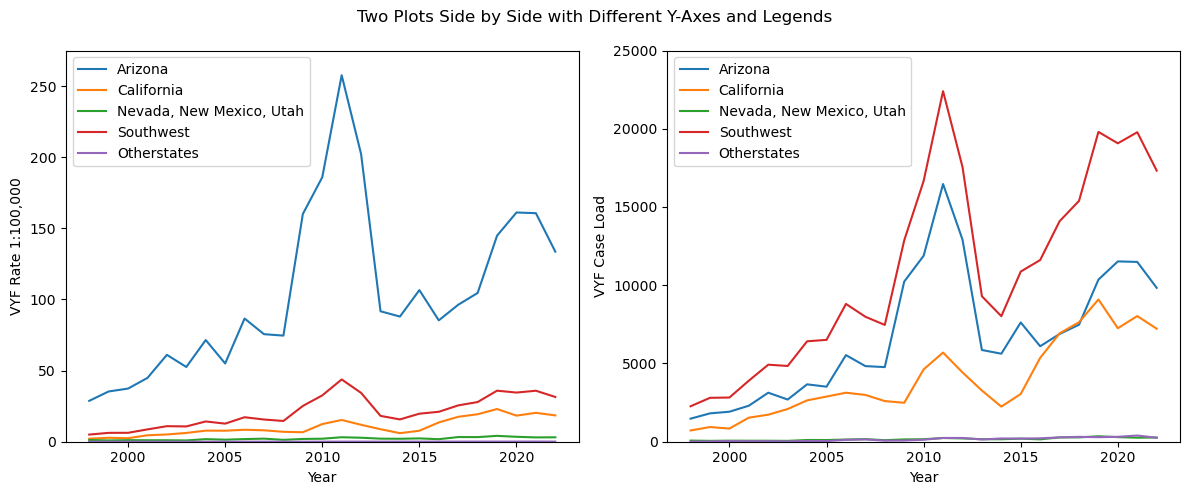

In [67]:
#plotting VYF case amt vs. rate 
df_plot1 = state[state['state'] == 'Plot 1']
df_plot2 = state[state['state'] == 'Plot 2']


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

# First plot with the primary y-axis
sns.lineplot(x='year', y='rate', data=state, ax = ax1, hue ='state')
ax1.set_xlabel('Year')
ax1.set_ylabel('VYF Rate 1:100,000')
ax1.set_ylim(0, 275)  # Set the y-axis limits for the first plot

# Create a second y-axis


# Second plot with the secondary y-axis
sns.lineplot(x='year', y='infected_count', ax = ax2, hue='state', data=state)
ax2.set_xlabel('Year')
ax2.set_ylabel('VYF Case Load')
ax2.set_ylim(0, 25000)  # Set the y-axis limits for the second plot

ax1.legend()
ax2.legend()

plt.suptitle('Two Plots Side by Side with Different Y-Axes and Legends')
plt.tight_layout()
plt.show()

In [68]:
statedf = state

In [ ]:
statedf.to_csv('/Users/maxi/Documents/coccid_dashboard/files/dataframe/statevyf.csv', index=False)

                    Annual Temperature and Precipitation data processing

In [ ]:
#monthly heat data by county AZ/CA
dfactmp  = pd.read_csv('/Users/maxi/Documents/coccid_dashboard/files/climate/caricalicnt.csv') 
#monthly precip data by county AZ/CA
dfacrain = pd.read_csv('/Users/maxi/Documents/coccid_dashboard/files/precipitation/caricalicnt1prcp.csv') 

In [ ]:
#filtering for summer months
valuestmp = ['Jun','Jul','Aug'] 
fltrtmp = dfactmp[dfactmp['month'].isin(valuestmp)] 
#average of temperature in june/july/aug 
fltrtmp1  = fltrtmp.groupby(['year','fips'])['temp'].mean().reset_index() 
#print(flrtmp1)

In [ ]:
#Precipitation: Fall/Winter
valuesprcp = ['oct','nov','dec'] #filtering for summer months
fltrprcp = dfacrain[dfacrain['month'].isin(valuestmp)] 
fltrprcp1  = fltrprcp.groupby(['year','fips'])['temp'].mean().reset_index() #average precipitation in jan/feb/mar
fltrprcp1 = fltrprcp1.rename(columns={'temp':'precipitation'}) #rename column to precipitation
print(fltrprcp1)

In [ ]:
#temp + precipitation merge
prctmp = pd.merge(fltrprcp1, fltrtmp1 , on = ['year','fips'], how = 'inner')
prctmp.dtypes



In [ ]:
#to be used for linear regression later 
prctmp

In [ ]:
#merging county temp, precipitation data with county, fips data.  2001 - 2021.
temprain_aricalitmpprc= pd.merge(#using both 
   aricalicensus,
    prctmp,
    how='left',
    left_on=['fips','year'],
    right_on=['fips','year']
)

In [ ]:
rainheat = temprain_aricalitmpprc
rainheat['key_column'] = range(1, len(rainheat) + 1)
print(rainheat)

#corr = temprain_aricalitmpprc.corr(method = 'spearman')
#heatmaptemp = sns.heatmap(corr, annot=True)

                                    Merging census with climate 

In [90]:
#merging population data with fips codes for county data relevant time span 2000-2021
total = pd.merge(censustotal, dfcensus, on = ['county','state'], how = 'inner')
#total = total.query('(state == "AZ") | (state == "CA")')

In [91]:
#temperature/precipitation + population data merge 
df = pd.merge(
    rainheat,total, 
    how='left',
    on=['fips','year','county','state'],)
   



In [92]:
#locate missing rows
df.tail()
missing_rows = rainheat[~rainheat['key_column'].isin(df['key_column'])]
print(missing_rows)

Empty DataFrame
Columns: [county, year, case, state, fips, precipitation, temp, key_column]
Index: []


In [93]:
#calculate case rate: (case/population) * 100,000
df['rate'] = df.apply(lambda row: row['case'] / row['population'], axis=1)
df['rate'] = df['rate'].apply(lambda x: x * 100000)

In [94]:
#df is a county level data frame from 2000-2021  including population, prec., temp., and fips data
#The temperature data if June,July,Aug of each respective year and Precipitation is Oct,Nov,Dec of each respective year
df

,county,year,case,state,fips,precipitation,temp,key_column,population,rate
0,alameda,2001,7.0,CA,6001,0.050000,69.333333,1,1469484.0,0.476358
1,alameda,2002,2.0,CA,6001,0.003333,68.800000,2,1462106.0,0.136789
2,alameda,2003,9.0,CA,6001,0.033333,70.133333,3,1454163.0,0.618913
3,alameda,2004,12.0,CA,6001,0.003333,69.033333,4,1445721.0,0.830036
4,alameda,2005,11.0,CA,6001,0.120000,69.500000,5,1441545.0,0.763070
...,...,...,...,...,...,...,...,...,...,...
1453,yuma,2017,28.0,AZ,4027,0.286667,92.300000,1454,209507.0,13.364709
1454,yuma,2018,27.0,AZ,4027,0.566667,91.766667,1455,211612.0,12.759201
1455,yuma,2019,65.0,AZ,4027,0.073333,90.966667,1456,213787.0,30.404094
1456,yuma,2020,52.0,AZ,4027,0.016667,92.466667,1457,204528.0,25.424392


                Rate, Temp Correlation, Exploratory Visualization of VYF by temperature data 

/var/folders/4l/rw6chbh96qzc93qthb09dj6m0000gn/T/ipykernel_68303/1065051597.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr(method = 'pearson') #just annual heat data, no precipitation


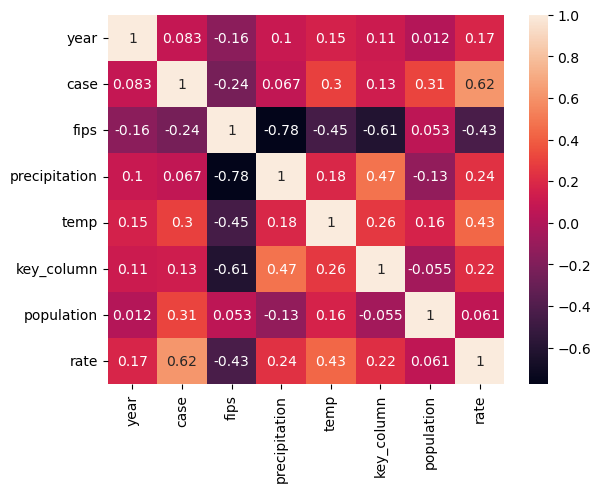

In [95]:
df
corr = df.corr(method = 'pearson') #just annual heat data, no precipitation
heatmaptemp = sns.heatmap(corr, annot=True)


<Axes: xlabel='temp', ylabel='case'>

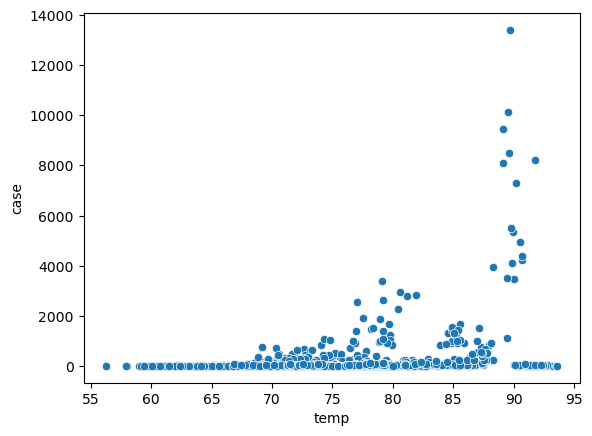

In [72]:
sns.scatterplot(x='temp',y='case',data =df)

dfa: county temp data 1895 - 2022 average as annual using summer months june,july,august
statedata: VYFV data 2001 - 2021 Cali, Arizona (2006 start)
dftotal: (2001, 2006) - 2021; Cali, Arizona precipitation, temp, tempchg, case, case rate data 
df (deprecated): dftotal - tmpchg

In [ ]:
                                County Level VYF, Temperature Change, Precipitation  

In [ ]:
dfcensus1 = pd.read_csv('/Users/maxi/Documents/coccid_dashboard/files/census/countyfips.csv')


In [76]:
dfa = pd.merge(dfcensus1,prctmp, on = 'fips', how='left')
substring_to_remove = ' County'
dfa['name'] = dfa['name'].str.replace(substring_to_remove, '')
dfa['name'] = dfa['name'].str.lower()
dfa = dfa.rename(columns = {'name':'county'})
dfa

,fips,county,state,year,precipitation,temp
0,4001,apache,AZ,1895,1.216667,67.366667
1,4001,apache,AZ,1896,1.310000,69.600000
2,4001,apache,AZ,1897,0.893333,68.033333
3,4001,apache,AZ,1898,2.023333,70.900000
4,4001,apache,AZ,1899,1.450000,69.300000
...,...,...,...,...,...,...
9412,6115,yuba,CA,2019,0.070000,76.766667
9413,6115,yuba,CA,2020,0.050000,77.566667
9414,6115,yuba,CA,2021,0.010000,79.500000
9415,6115,yuba,CA,2022,0.290000,77.700000


In [ ]:
This section is where the magic happens. With the statsmodel library we apply a linear regression using a
ordinary least squares method to model a relationship between year and temperature. The slope of this model provides 
an estimate of the rate of temperature change. This can then be applied throughout the time series to find 
temperature-change data for any point in time.
Note: This is one approach that uses annual temperature starting in 1895 data set to formulate 
      an estimate of temperature change. 


In [77]:
#linear model 
def extract_model_variables(dfa):
    # Group the data by some criteria (e.g., state, county, fips) to calculate tempchg_c
    grouped = dfa.groupby(['state', 'county', 'fips'])
    
    for group, group_df in grouped:
        # Fit a linear regression model within each group
        model = sm.OLS(group_df['temp'], sm.add_constant(group_df['year'])).fit()
        
        # Calculate model variables for each group
        slope = model.params['year']
        tempchg = 0
        tempchg_c = 0

        # Assign the tempchg_c value back to the original rows in the DataFrame
        dfa.loc[group_df.index, 'tempchg_c'] = tempchg_c
        dfa.loc[group_df.index, 'tempchg'] = tempchg
        dfa.loc[group_df.index, 'slope'] = slope

    # Create a 'bin' variable based on 'tempchg_c'
    bins = [-float("inf"), 0, 0.5, 1.0, 1.5, 2, float("inf")]
    dfa['bin'] = pd.cut(dfa['tempchg_c'], bins=bins)

    return dfa

# Apply the function to your DataFrame 'dfa' to add the model variables
dfa = extract_model_variables(dfa)

# Display the modified DataFrame with model variables and the 'bin' column
print(dfa)

      fips  county state  year  precipitation       temp  tempchg_c  tempchg  \
0     4001  apache    AZ  1895       1.216667  67.366667        0.0      0.0   
1     4001  apache    AZ  1896       1.310000  69.600000        0.0      0.0   
2     4001  apache    AZ  1897       0.893333  68.033333        0.0      0.0   
3     4001  apache    AZ  1898       2.023333  70.900000        0.0      0.0   
4     4001  apache    AZ  1899       1.450000  69.300000        0.0      0.0   
...    ...     ...   ...   ...            ...        ...        ...      ...   
9412  6115    yuba    CA  2019       0.070000  76.766667        0.0      0.0   
9413  6115    yuba    CA  2020       0.050000  77.566667        0.0      0.0   
9414  6115    yuba    CA  2021       0.010000  79.500000        0.0      0.0   
9415  6115    yuba    CA  2022       0.290000  77.700000        0.0      0.0   
9416  6115    yuba    CA  2023       0.130000  76.333333        0.0      0.0   

         slope          bin  
0     0.0

In [78]:
#dfa.loc[dfa['county'] == 'maricopa']
baseline_year = 1895 #to show deviation from baseline

for index,row in dfa.iterrows():
    if row['year'] > baseline_year:
        years_difference = row['year'] - baseline_year
        slope_value = row['slope']
        tempch_value = dfa.at[index, 'tempchg']
        new_tempch = tempch_value + (slope_value * years_difference)
        dfa.at[index,'tempchg'] = new_tempch
        




In [83]:
dfa

,fips,county,state,year,precipitation,temp,tempchg_c,tempchg,slope,bin
0,4001,apache,AZ,1895,1.216667,67.366667,0.000000,0.000000,0.012371,"(-inf, 0.0]"
1,4001,apache,AZ,1896,1.310000,69.600000,0.006873,0.012371,0.012371,"(-inf, 0.0]"
2,4001,apache,AZ,1897,0.893333,68.033333,0.013746,0.024743,0.012371,"(-inf, 0.0]"
3,4001,apache,AZ,1898,2.023333,70.900000,0.020619,0.037114,0.012371,"(-inf, 0.0]"
4,4001,apache,AZ,1899,1.450000,69.300000,0.027492,0.049486,0.012371,"(-inf, 0.0]"
...,...,...,...,...,...,...,...,...,...,...
9412,6115,yuba,CA,2019,0.070000,76.766667,1.341102,2.413984,0.019468,"(-inf, 0.0]"
9413,6115,yuba,CA,2020,0.050000,77.566667,1.351918,2.433452,0.019468,"(-inf, 0.0]"
9414,6115,yuba,CA,2021,0.010000,79.500000,1.362733,2.452919,0.019468,"(-inf, 0.0]"
9415,6115,yuba,CA,2022,0.290000,77.700000,1.373548,2.472387,0.019468,"(-inf, 0.0]"


In [84]:
#creating tempchange column in celsius
dfa['tempchg_c'] = dfa.apply(lambda row: row['tempchg'] / 1.8, axis=1)
dfa = dfa.fillna(0)
dfa

,fips,county,state,year,precipitation,temp,tempchg_c,tempchg,slope,bin
0,4001,apache,AZ,1895,1.216667,67.366667,0.000000,0.000000,0.012371,"(-inf, 0.0]"
1,4001,apache,AZ,1896,1.310000,69.600000,0.006873,0.012371,0.012371,"(-inf, 0.0]"
2,4001,apache,AZ,1897,0.893333,68.033333,0.013746,0.024743,0.012371,"(-inf, 0.0]"
3,4001,apache,AZ,1898,2.023333,70.900000,0.020619,0.037114,0.012371,"(-inf, 0.0]"
4,4001,apache,AZ,1899,1.450000,69.300000,0.027492,0.049486,0.012371,"(-inf, 0.0]"
...,...,...,...,...,...,...,...,...,...,...
9412,6115,yuba,CA,2019,0.070000,76.766667,1.341102,2.413984,0.019468,"(-inf, 0.0]"
9413,6115,yuba,CA,2020,0.050000,77.566667,1.351918,2.433452,0.019468,"(-inf, 0.0]"
9414,6115,yuba,CA,2021,0.010000,79.500000,1.362733,2.452919,0.019468,"(-inf, 0.0]"
9415,6115,yuba,CA,2022,0.290000,77.700000,1.373548,2.472387,0.019468,"(-inf, 0.0]"


In [96]:
#merging the valley fever data frame (df) with dfa where all the temp and precip data is held 
dftotal = pd.merge(df,dfa, on = ['fips','county','year','state'], how = 'left')
dftotal = dftotal.drop({'temp_y'}, axis = 1)
dftotal = dftotal.drop({'precipitation_y'}, axis = 1)
dftotal = dftotal.set_index('key_column')
dftotal = dftotal.rename(columns = {'temp_x':'temp'})
dftotal = dftotal.rename(columns = {'precipitation_x':'precipitation'})
dftotal = dftotal.replace('CA', 'California')
dftotal = dftotal.replace('AZ', 'Arizona')


In [109]:
dftotal = dftotal.reset_index()
dftotal

,index,key_column,county,year,case,state,fips,precipitation,temp,population,rate,tempchg_c,tempchg,slope,bin
0,0,1,alameda,2001,7.0,California,6001,0.050000,69.333333,1469484.0,0.476358,1.705609,3.070097,0.028963,"(-inf, 0.0]"
1,1,2,alameda,2002,2.0,California,6001,0.003333,68.800000,1462106.0,0.136789,1.721700,3.099060,0.028963,"(-inf, 0.0]"
2,2,3,alameda,2003,9.0,California,6001,0.033333,70.133333,1454163.0,0.618913,1.737791,3.128023,0.028963,"(-inf, 0.0]"
3,3,4,alameda,2004,12.0,California,6001,0.003333,69.033333,1445721.0,0.830036,1.753881,3.156986,0.028963,"(-inf, 0.0]"
4,4,5,alameda,2005,11.0,California,6001,0.120000,69.500000,1441545.0,0.763070,1.769972,3.185950,0.028963,"(-inf, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,1453,1454,yuma,2017,28.0,Arizona,4027,0.286667,92.300000,209507.0,13.364709,1.992260,3.586069,0.029394,"(-inf, 0.0]"
1454,1454,1455,yuma,2018,27.0,Arizona,4027,0.566667,91.766667,211612.0,12.759201,2.008590,3.615463,0.029394,"(-inf, 0.0]"
1455,1455,1456,yuma,2019,65.0,Arizona,4027,0.073333,90.966667,213787.0,30.404094,2.024920,3.644857,0.029394,"(-inf, 0.0]"
1456,1456,1457,yuma,2020,52.0,Arizona,4027,0.016667,92.466667,204528.0,25.424392,2.041250,3.674251,0.029394,"(-inf, 0.0]"


<Axes: xlabel='tempchg', ylabel='rate'>

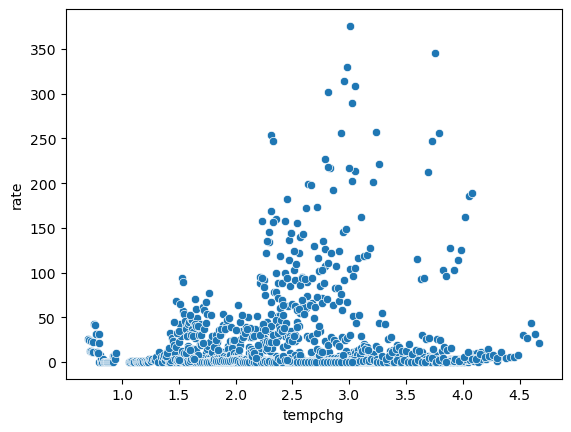

In [110]:
sns.scatterplot(x='tempchg',y='rate',data =dftotal)

<Axes: >

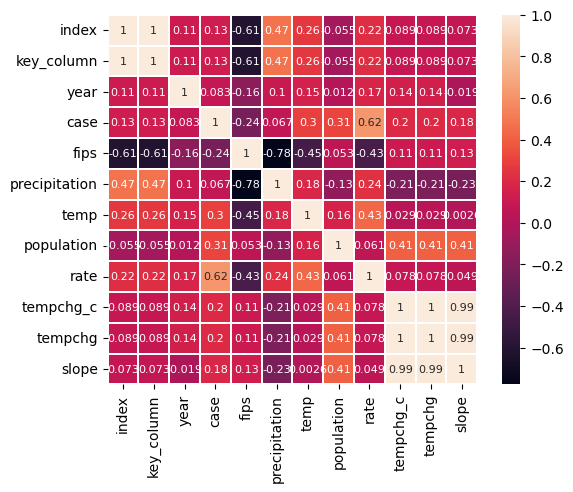

In [117]:
#dftotal
#corr = dftotal.corr(method = 'pearson') #just annual heat data, no precipitation
#heatmaptemp = sns.heatmap(corr, annot=True)
#print(corr)
sns.heatmap(corr, vmin=corr.values.min(), vmax=1, square=True, 
        linewidths=0.1, annot=True, annot_kws={"size":8})

In [119]:
#concatenating state and testconcat for ease of analysis in tableau later 
state = state.rename(columns = {'infected_count':'case'})
testconcat = pd.concat([dftotal, state],ignore_index = True)

In [142]:
testconcat
testconcat.to_csv('/Users/maxi/Documents/coccid_dashboard/files/dataframe/countystatetot2.csv', index=False) #export for tableau

In [136]:
testconcat

,index,key_column,county,year,case,state,fips,precipitation,temp,population,rate,tempchg_c,tempchg,slope,bin
0,0.0,1.0,alameda,2001,7.0,California,6001.0,0.050000,69.333333,1469484.0,0.476358,1.705609,3.070097,0.028963,"(-inf, 0.0]"
1,1.0,2.0,alameda,2002,2.0,California,6001.0,0.003333,68.800000,1462106.0,0.136789,1.721700,3.099060,0.028963,"(-inf, 0.0]"
2,2.0,3.0,alameda,2003,9.0,California,6001.0,0.033333,70.133333,1454163.0,0.618913,1.737791,3.128023,0.028963,"(-inf, 0.0]"
3,3.0,4.0,alameda,2004,12.0,California,6001.0,0.003333,69.033333,1445721.0,0.830036,1.753881,3.156986,0.028963,"(-inf, 0.0]"
4,4.0,5.0,alameda,2005,11.0,California,6001.0,0.120000,69.500000,1441545.0,0.763070,1.769972,3.185950,0.028963,"(-inf, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1578,NaN,NaN,NaN,2002,32.0,Otherstates,NaN,NaN,NaN,231925043.0,0.013798,NaN,NaN,NaN,NaN
1579,NaN,NaN,NaN,2001,30.0,Otherstates,NaN,NaN,NaN,231925043.0,0.012935,NaN,NaN,NaN,NaN
1580,NaN,NaN,NaN,2000,41.0,Otherstates,NaN,NaN,NaN,231925043.0,0.017678,NaN,NaN,NaN,NaN
1581,NaN,NaN,NaN,1999,20.0,Otherstates,NaN,NaN,NaN,231925043.0,0.008623,NaN,NaN,NaN,NaN
